In [85]:
from xml.dom import minidom
import pandas as pd
import math  


def geo2cart(lon,lat,h):
    a=6378137 #WGS 84 Major axis
    b=6356752.3142 #WGS 84 Minor axis
    e2=1-(b**2/a**2)
    N=float(a/math.sqrt(1-e2*(math.sin(math.radians(abs(lat)))**2)))
    X=(N+h)*math.cos(math.radians(lat))*math.cos(math.radians(lon))
    Y=(N+h)*math.cos(math.radians(lat))*math.sin(math.radians(lon))
    return X,Y

def distance(row):
    d=math.sqrt((row['X_next']-row['X'])**2+(row['Y_next']-row['Y'])**2)
    return d


def plotElevation(path, name):
    '''
    Plot elevation profile from a GPX route
    Note that this function was adapted from
    https://www.geodose.com/2018/04/create-gpx-tracking-file-visualizer-python.html
    '''
    #READ GPX FILE
    with open(path, 'r') as f:
        xmldoc = minidom.parse(f)
    track = xmldoc.getElementsByTagName('trkpt')
    elevation=xmldoc.getElementsByTagName('ele')
    datetime=xmldoc.getElementsByTagName('time')
    n_track=len(track)
    #PARSE GPX FILE
    lon_list=[]
    lat_list=[]
    h_list=[]
    time_list=[]
    x_list = []
    y_list = []
    for s in range(n_track):
        lon,lat=track[s].attributes['lon'].value,track[s].attributes['lat'].value
        elev=elevation[s].firstChild.nodeValue
        X,Y = geo2cart(float(lon),float(lat), float(elev))
        lon_list.append(float(lon))
        lat_list.append(float(lat))
        h_list.append(float(elev)) # convert meters to feet
        x_list.append(X)
        y_list.append(Y)

    
    df = pd.DataFrame({'lon':lon_list, 'lat':lat_list, 'elev':h_list, 'X':x_list, 'Y':y_list})
    # Calc distance
    df['X_next'] = df['X'].shift(-1)
    df['Y_next'] = df['Y'].shift(-1)
    df['elev_next'] = df['elev'].shift(-1)
    df['elev_delta'] = df['elev_next'] - df['elev']
    df['elev_gain'] = df['elev_delta'].map(lambda x: max(0,x))
    df['cum_elev_gain'] = df['elev_gain'].cumsum()
    df['distance'] = df.apply(distance, axis=1)
    df['cum_dist'] = df['distance'].cumsum()
    df['person'] = name
    return df.dropna()

In [112]:
david_df = plotElevation('Elevation_week.gpx', 'David')
george_df = plotElevation('George Hampstead.gpx', 'George')
lorna_df = plotElevation('Lorna Hills.gpx', 'Lorna')
wilso_df = plotElevation('wilso_hils.gpx', 'Wilso')

Text(0, 0.5, 'Vertical gain m')

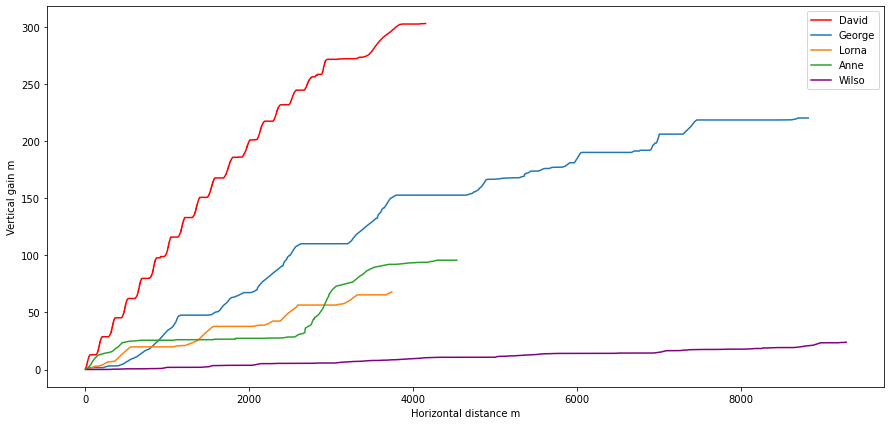

In [115]:
ax = david_df.set_index('cum_dist')['cum_elev_gain'].plot(figsize=(15,7), color='red')
george_df.set_index('cum_dist')['cum_elev_gain'].plot(ax=ax)
lorna_df.set_index('cum_dist')['cum_elev_gain'].plot(ax=ax)
anne_df.set_index('cum_dist')['cum_elev_gain'].plot(ax=ax)
wilso_df.set_index('cum_dist')['cum_elev_gain'].plot(ax=ax, color='purple')


ax.legend(["David", "George", "Lorna", "Anne", "Wilso"])
ax.set_xlabel('Horizontal distance m')
ax.set_ylabel('Vertical gain m')